<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score, auc
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, computePrMetric
from src.main.settings_model import parse_args, MODEL_CLASS
import test

# load the model and use valid data to choose hyperpparams for the different cp methods

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_16_data_id_1_geo/') 
dataset_type='valid'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
params.balancedLoss=False
results, valid_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 28.0632 secs
Finished '__init__' in 49.0397 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'l1_loss': 0.25601929560223197, 'mse': 0.05753795484154882, 'smooth_l1': 0.028751765775740297, 'weighted_loss': 0.25601929560223197, 'loss_main': 11682.939402294503, 'loss_aux': 13118.319079117246}
at epoch : 102
train loss metrics: {'l1_loss': 0.18589353178125714, 'mse': 0.03726004589822216, 'smooth_l1': 0.01862237257723985, 'weighted_loss': 0.18589353178125714, 'loss_main': 172038.39658658422, 'loss_aux': 10996957.3358706}
best val cp metrics : {'loss_cp': 0.088285782759091, 'prMetrics': OrderedDict([('Precision', array(0.)), ('Recall', array(0.)), ('Accuracy', array(0.98634977)), ('A_major', array(1.)), ('BalancedAccuracy', 0.5)])}
train cp metrics: {'loss_cp': 0.20319076709971257, 'prMetrics': Ord

In [8]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.2513376158995398,
  'loss_aux': 2925.764497644873,
  'loss_main': 1260.870759258459,
  'mse': 0.05369292483612689,
  'smooth_l1': 0.026826194346783037,
  'weighted_loss': 0.2513376158995398},
 {'loss_cp': 0.2002661882926948,
  'prMetrics': OrderedDict([('Precision', array(0.06134969)),
               ('Recall', array(0.00125676)),
               ('Accuracy', array(0.99299944)),
               ('A_major', array(0.99986685)),
               ('BalancedAccuracy', 0.5005618032832708)])})

In [9]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [10]:
def reportChangePointMetrics1(name : str, cp_pred_raw: torch.Tensor, cp_target: torch.tensor, cpThresh: float, win_tol=2)->t_prMetrics:
    Batch_size, T = cp_target.shape[0], cp_target.shape[1]
    cp_pred = getCpPred(name, cp_pred_raw, cpThresh, Batch_size, T)
    prCounts = eval_cp_batch(cp_target, cp_pred, T, win_tol=win_tol)
    prMetrics = computePrMetric(prCounts)
    print(f"prCounts:{prCounts}")

    return prMetrics, cp_pred

In [11]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics1(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [12]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.3, 0.5)
df_nn.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=6588.0, FP=334691.0, TN=814402.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334689.0, TN=814404.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334686.0, TN=814407.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334685.0, TN=814408.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334678.0, TN=814415.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334658.0, TN=814435.0, FN=1369.0)
prCounts:PrCounts(TP=6588.0, FP=334600.0, TN=814493.0, FN=1369.0)
prCounts:PrCounts(TP=6583.0, FP=334313.0, TN=814780.0, FN=1374.0)
prCounts:PrCounts(TP=6568.0, FP=333070.0, TN=816023.0, FN=1389.0)
prCounts:PrCounts(TP=6519.0, FP=328342.0, TN=820751.0, FN=1438.0)
prCounts:PrCounts(TP=6383.0, FP=315796.0, TN=833297.0, FN=1574.0)
prCounts:PrCounts(TP=6113.0, FP=290113.0, TN=858980.0, FN=1844.0)
prCounts:PrCounts(TP=5577.0, FP=245423.0, TN=903670.0, FN=2380.0)
prCounts:PrCounts(TP=4929.0, FP=196673.0, TN=952420.0, FN=3028.0)
prCounts:PrCounts(TP=4275.0, FP=155015.0, TN=994078.0, FN=3682.0)
prCounts:P

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=0.0, TN=1149093.0, FN=7957.0)
Finished 'prMetricsByThresh' in 20.4666 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.019303854031452274,0.8279502324996858,0.7095544704204658,0.7087346280936356,0.768342,0.300000,0.037728
1,0.019303967158642393,0.8279502324996858,0.709556198954237,0.7087363685967977,0.768343,0.310000,0.037728
2,0.019304136851913713,0.8279502324996858,0.7095587917548939,0.7087389793515407,0.768345,0.320000,0.037729
3,0.019304193417000466,0.8279502324996858,0.7095596560217795,0.7087398496031218,0.768345,0.330000,0.037729
4,0.019304589381889788,0.8279502324996858,0.7095657058899788,0.708745941364189,0.768348,0.340000,0.037729
5,0.019305720799657724,0.8279502324996858,0.7095829912276911,0.7087633463958095,0.768357,0.350000,0.037732
6,0.019309002661289376,0.8279502324996858,0.7096331187070567,0.7088138209875092,0.768382,0.360000,0.037738
7,0.019310874870928377,0.8273218549704663,0.7098768419688,0.7090635831912647,0.768193,0.370000,0.037741
8,0.01933823659307851,0.8254367223828076,0.7109381617043343,0.7101453059064845,0.767791,0.380000,0.037791
9,0.019467779168072723,0.8192786225964559,0.7149820664621235,0.7142598553815923,0.766769,0.390000,0.038032


In [13]:
nnThresh=0.47

# gradient method, choose the threshold for gradient difference in predictions

In [14]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,2)
df_grad.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1114866.0, TN=34227.0, FN=0.0)
prCounts:PrCounts(TP=4690.0, FP=5736.0, TN=1143357.0, FN=3267.0)
prCounts:PrCounts(TP=3412.0, FP=1293.0, TN=1147800.0, FN=4545.0)
prCounts:PrCounts(TP=2685.0, FP=475.0, TN=1148618.0, FN=5272.0)
prCounts:PrCounts(TP=2163.0, FP=232.0, TN=1148861.0, FN=5794.0)
prCounts:PrCounts(TP=1754.0, FP=108.0, TN=1148985.0, FN=6203.0)
prCounts:PrCounts(TP=1347.0, FP=60.0, TN=1149033.0, FN=6610.0)
prCounts:PrCounts(TP=1067.0, FP=38.0, TN=1149055.0, FN=6890.0)
prCounts:PrCounts(TP=850.0, FP=24.0, TN=1149069.0, FN=7107.0)
prCounts:PrCounts(TP=646.0, FP=15.0, TN=1149078.0, FN=7311.0)
prCounts:PrCounts(TP=483.0, FP=11.0, TN=1149082.0, FN=7474.0)
prCounts:PrCounts(TP=340.0, FP=7.0, TN=1149086.0, FN=7617.0)
prCounts:PrCounts(TP=206.0, FP=6.0, TN=1149087.0, FN=7751.0)
prCounts:PrCounts(TP=105.0, FP=6.0, TN=1149087.0, FN=7852.0)
prCounts:PrCounts(TP=47.0, FP=2.0, TN=1149091.0, FN=7910.0)
prCounts:PrCounts(TP=25.0, FP=0.0, TN=1149093.0, FN=7932.0)


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007086602251646075,1.0,0.03645823430275269,0.029786100863898744,0.514893,0.000000,0.014073
1,0.4498369460962977,0.5894181224079427,0.9922190052288147,0.9950082369312144,0.792213,0.100000,0.510254
2,0.7251859723698193,0.4288048259394244,0.9949544099217839,0.9988747647057288,0.713840,0.200000,0.538935
3,0.8496835443037974,0.3374387331909011,0.9950330582083747,0.999586630499011,0.668513,0.300000,0.483044
4,0.9031315240083507,0.27183611914037953,0.9947919277472884,0.9997981016332012,0.635817,0.400000,0.417890
5,0.9419978517722879,0.22043483725021992,0.9945456116848883,0.9999060128292488,0.610170,0.500000,0.357267
6,0.9573560767590619,0.16928490637174815,0.9942353398729528,0.9999477849051382,0.584616,0.600000,0.287698
7,0.9656108597285068,0.13409576473545307,0.9940123590164642,0.9999669304399209,0.567031,0.700000,0.235489
8,0.9725400457665904,0.10682417996732436,0.9938369128386846,0.9999791139620553,0.553402,0.800000,0.192504
9,0.9773071104387292,0.08118637677516652,0.9936683807959898,0.9999869462262846,0.540587,0.900000,0.149919


In [15]:
gradThresh=0.1

# mc dropout variance, choose the threshold for difference in variance

In [16]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0, 0.3)
df_var.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1118498.0, TN=30595.0, FN=0.0)
prCounts:PrCounts(TP=3671.0, FP=92488.0, TN=1056605.0, FN=4286.0)
prCounts:PrCounts(TP=2117.0, FP=30495.0, TN=1118598.0, FN=5840.0)
prCounts:PrCounts(TP=1267.0, FP=14714.0, TN=1134379.0, FN=6690.0)
prCounts:PrCounts(TP=786.0, FP=7380.0, TN=1141713.0, FN=7171.0)
prCounts:PrCounts(TP=575.0, FP=4469.0, TN=1144624.0, FN=7382.0)
prCounts:PrCounts(TP=427.0, FP=2994.0, TN=1146099.0, FN=7530.0)
prCounts:PrCounts(TP=329.0, FP=2093.0, TN=1147000.0, FN=7628.0)
prCounts:PrCounts(TP=281.0, FP=1580.0, TN=1147513.0, FN=7676.0)
prCounts:PrCounts(TP=235.0, FP=1279.0, TN=1147814.0, FN=7722.0)
prCounts:PrCounts(TP=210.0, FP=1046.0, TN=1148047.0, FN=7747.0)
prCounts:PrCounts(TP=188.0, FP=835.0, TN=1148258.0, FN=7769.0)
prCounts:PrCounts(TP=158.0, FP=613.0, TN=1148480.0, FN=7799.0)
prCounts:PrCounts(TP=140.0, FP=487.0, TN=1148606.0, FN=7817.0)
prCounts:PrCounts(TP=128.0, FP=418.0, TN=1148675.0, FN=7829.0)
prCounts:PrCounts(TP=111.0, FP=361.0, T

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007063753101544225,1.0,0.033319216974201635,0.026625347121599384,0.513313,0.000000,0.014028
1,0.038176353747439135,0.46135478195299734,0.9163614364115639,0.9195121717737381,0.690433,0.015000,0.070517
2,0.06491475530479578,0.26605504587155965,0.9685968627112053,0.9734616780365035,0.619758,0.030000,0.104365
3,0.07928164695575997,0.15923086590423527,0.981501231580312,0.987195118236731,0.573213,0.045000,0.105857
4,0.09625275532696546,0.09878094759331406,0.9874240525474266,0.9935775433320019,0.546179,0.060000,0.097500
5,0.11399682791435369,0.07226341586024884,0.9897575731385851,0.9961108456843789,0.534187,0.075000,0.088455
6,0.12481730488161356,0.053663440995350004,0.9909044552957953,0.9973944667663975,0.525529,0.090000,0.075057
7,0.13583815028901733,0.04134724142264672,0.9915984616049436,0.9981785634409052,0.519763,0.105000,0.063397
8,0.1509940891993552,0.035314817142139,0.9920003457067542,0.9986250025019733,0.516970,0.120000,0.057242
9,0.15521796565389695,0.029533743873319092,0.9922207337625859,0.9988869482278632,0.514210,0.135000,0.049625


In [17]:
varThresh=0.10

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [18]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, log_prob_r_joint_x, log_p_xt1_given_xt, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 191.0020 secs


In [19]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,10)
df_bocd.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=2886.0, FP=1024.0, TN=1148069.0, FN=5071.0)
prCounts:PrCounts(TP=2886.0, FP=1024.0, TN=1148069.0, FN=5071.0)
prCounts:PrCounts(TP=2886.0, FP=1024.0, TN=1148069.0, FN=5071.0)
prCounts:PrCounts(TP=4202.0, FP=2571.0, TN=1146522.0, FN=3755.0)
prCounts:PrCounts(TP=4202.0, FP=2571.0, TN=1146522.0, FN=3755.0)
prCounts:PrCounts(TP=4574.0, FP=3904.0, TN=1145189.0, FN=3383.0)
prCounts:PrCounts(TP=4574.0, FP=3904.0, TN=1145189.0, FN=3383.0)
prCounts:PrCounts(TP=4739.0, FP=5157.0, TN=1143936.0, FN=3218.0)
prCounts:PrCounts(TP=4739.0, FP=5157.0, TN=1143936.0, FN=3218.0)
prCounts:PrCounts(TP=4813.0, FP=6124.0, TN=1142969.0, FN=3144.0)
prCounts:PrCounts(TP=4813.0, FP=6124.0, TN=1142969.0, FN=3144.0)
prCounts:PrCounts(TP=4813.0, FP=6124.0, TN=1142969.0, FN=3144.0)
prCounts:PrCounts(TP=4864.0, FP=7009.0, TN=1142084.0, FN=3093.0)
prCounts:PrCounts(TP=4864.0, FP=7009.0, TN=1142084.0, FN=3093.0)
prCounts:PrCounts(TP=4901.0, FP=7684.0, TN=1141409.0, FN=3056.0)
prCounts:PrCounts(TP=4901

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.7381074168797954,0.36269950986552724,0.9947322933321809,0.9991088623810257,0.680904,1.000000,0.486391
1,0.7381074168797954,0.36269950986552724,0.9947322933321809,0.9991088623810257,0.680904,1.450000,0.486391
2,0.7381074168797954,0.36269950986552724,0.9947322933321809,0.9991088623810257,0.680904,1.900000,0.486391
3,0.6204045474678872,0.5280884755561142,0.9945326476816041,0.997762583185173,0.762926,2.350000,0.570536
4,0.6204045474678872,0.5280884755561142,0.9945326476816041,0.997762583185173,0.762926,2.800000,0.570536
5,0.5395140363293229,0.574839763730049,0.9937020872045288,0.9966025378276606,0.785721,3.250000,0.556617
6,0.5395140363293229,0.574839763730049,0.9937020872045288,0.9966025378276606,0.785721,3.700000,0.556617
7,0.47888035569927245,0.5955762221942943,0.9927617648329804,0.9955121125966305,0.795544,4.150000,0.530891
8,0.47888035569927245,0.5955762221942943,0.9927617648329804,0.9955121125966305,0.795544,4.600000,0.530891
9,0.44006583158087226,0.6048762096267437,0.9919899745041268,0.994670579317775,0.799773,5.050000,0.509474


In [20]:
bocdThresh=3.0

# Summary Table with chosen thresholds

In [21]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9931178427898535,0.9999947784905138,0.5000,0.4700,nan,neural_network
1,0.4498369460962977,0.5894181224079427,0.9922190052288147,0.9950082369312144,0.7922,0.1000,0.5103,gradient
2,0.13076923076923078,0.044866155586276234,0.9913806663497688,0.9979348929982168,0.5214,0.1000,0.0668,mc_dropout
3,0.5395140363293229,0.574839763730049,0.9937020872045288,0.9966025378276606,0.7857,3.0000,0.5566,BOCD


plot of Precision/Recall

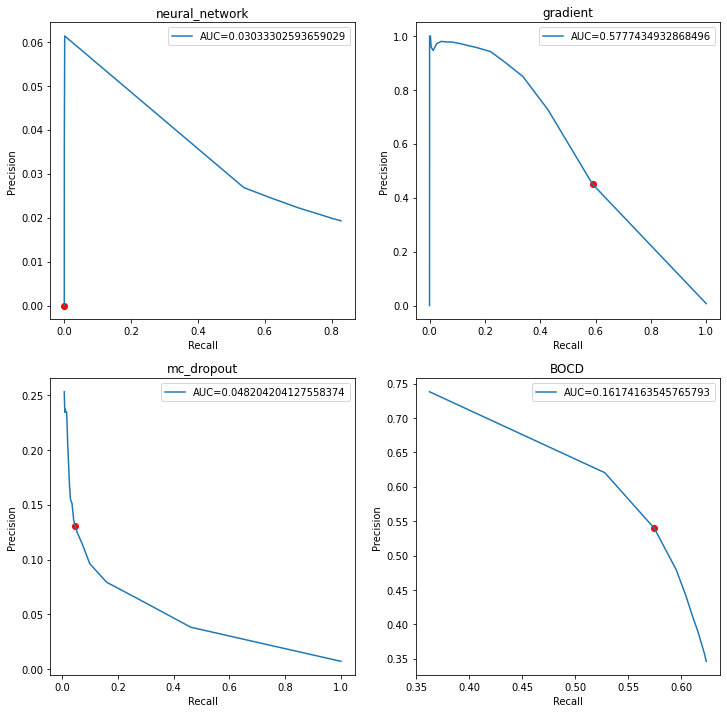

In [22]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    line1=ax[row,col].plot(df['Recall'], df['Precision'], label="AUC="+str(auc(df['Recall'], df['Precision'])))
    ax[row,col].set_ylabel('Precision')
    ax[row,col].set_xlabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Recall'], df_row['Precision'], color='r')
    ax[row,col].legend(handles=line1, loc="best")
plt.show()

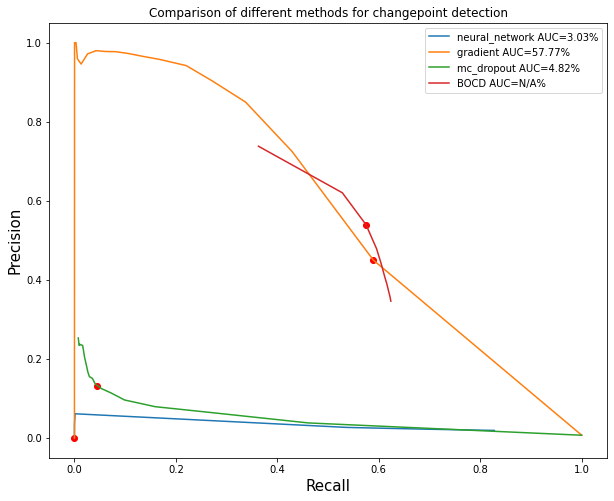

In [23]:
fig, ax = plt.subplots(figsize=[10,8])

for df, name in zip([df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    aucScore = "N/A"
    if name!="BOCD":
        aucScore = format(auc(df['Recall'], df['Precision'])*100, ".2f")
    plt.plot(df['Recall'], df['Precision'], label=str(name) + " AUC="+ str(aucScore)+"%")
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Recall', fontsize=15)
    plt.title("Comparison of different methods for changepoint detection")
    df_row=df_summary[df_summary.Name==name]
    plt.scatter(df_row['Recall'], df_row['Precision'], color='r')
    plt.legend(loc="best")
plt.show()

# Qualitative by looking at anecdotes/samples

In [24]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [25]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

In [26]:
np.sum(pred_cps[cpMethod.mc_dropout.name][3648,:])

1.0

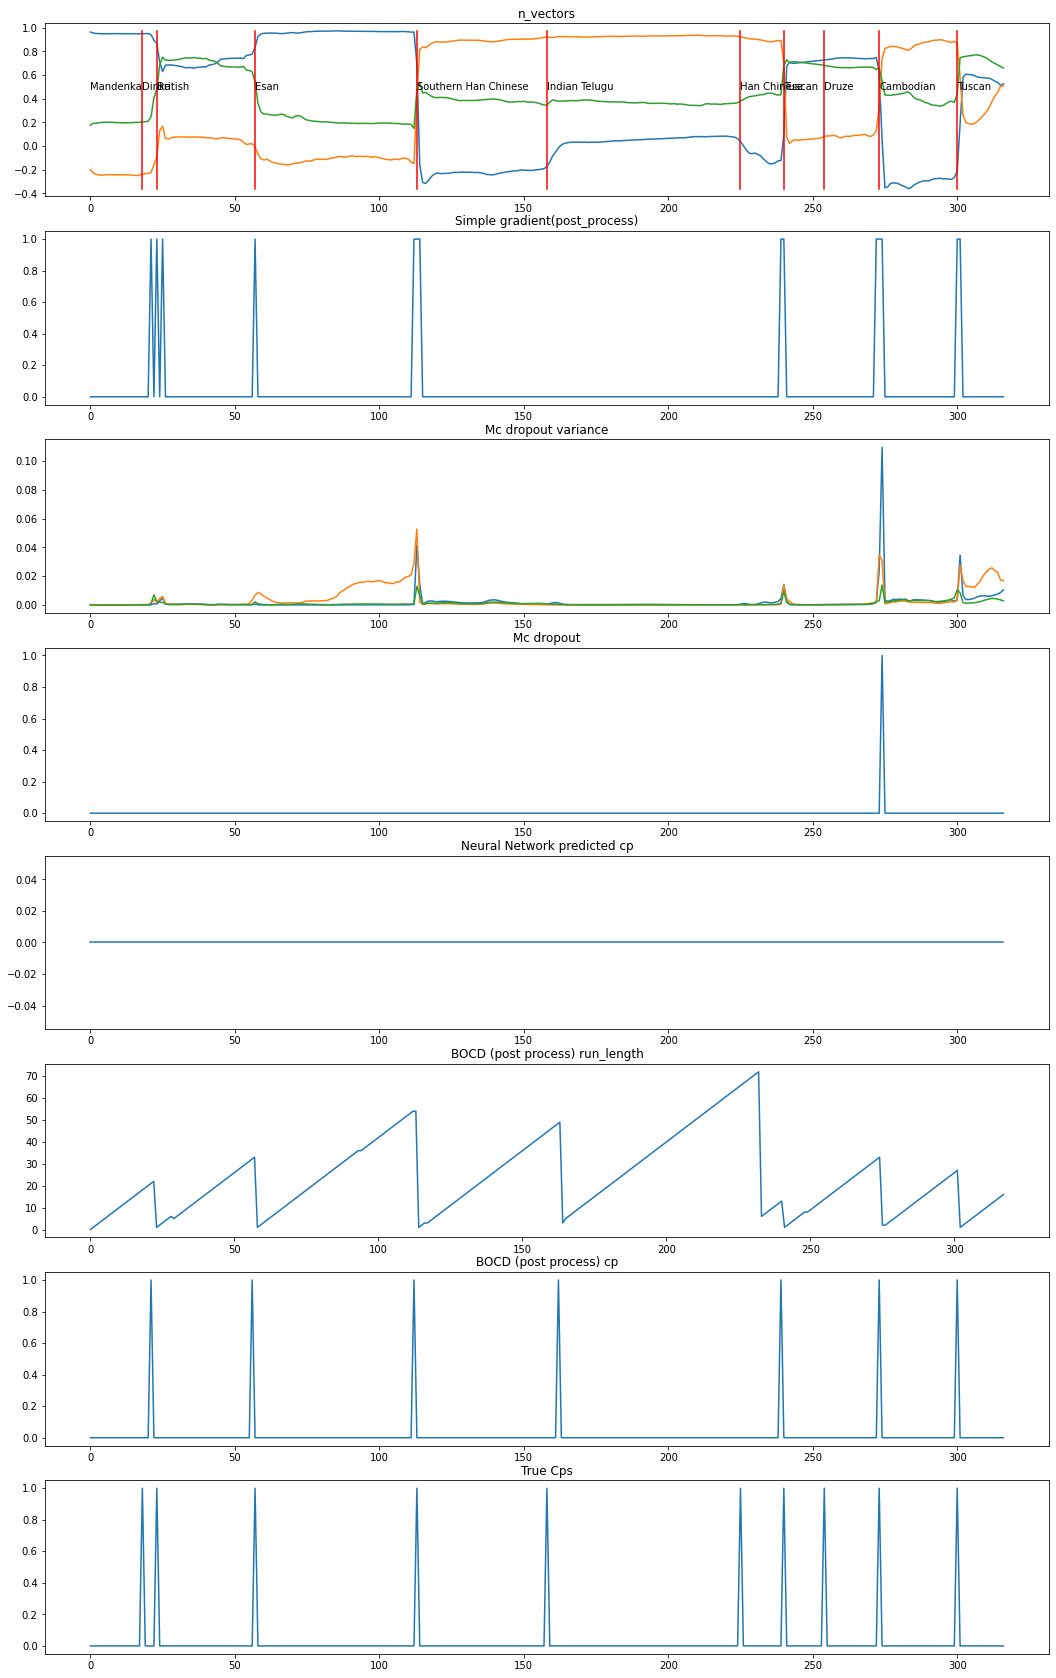

In [27]:
# index = 2000
index = 3648
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

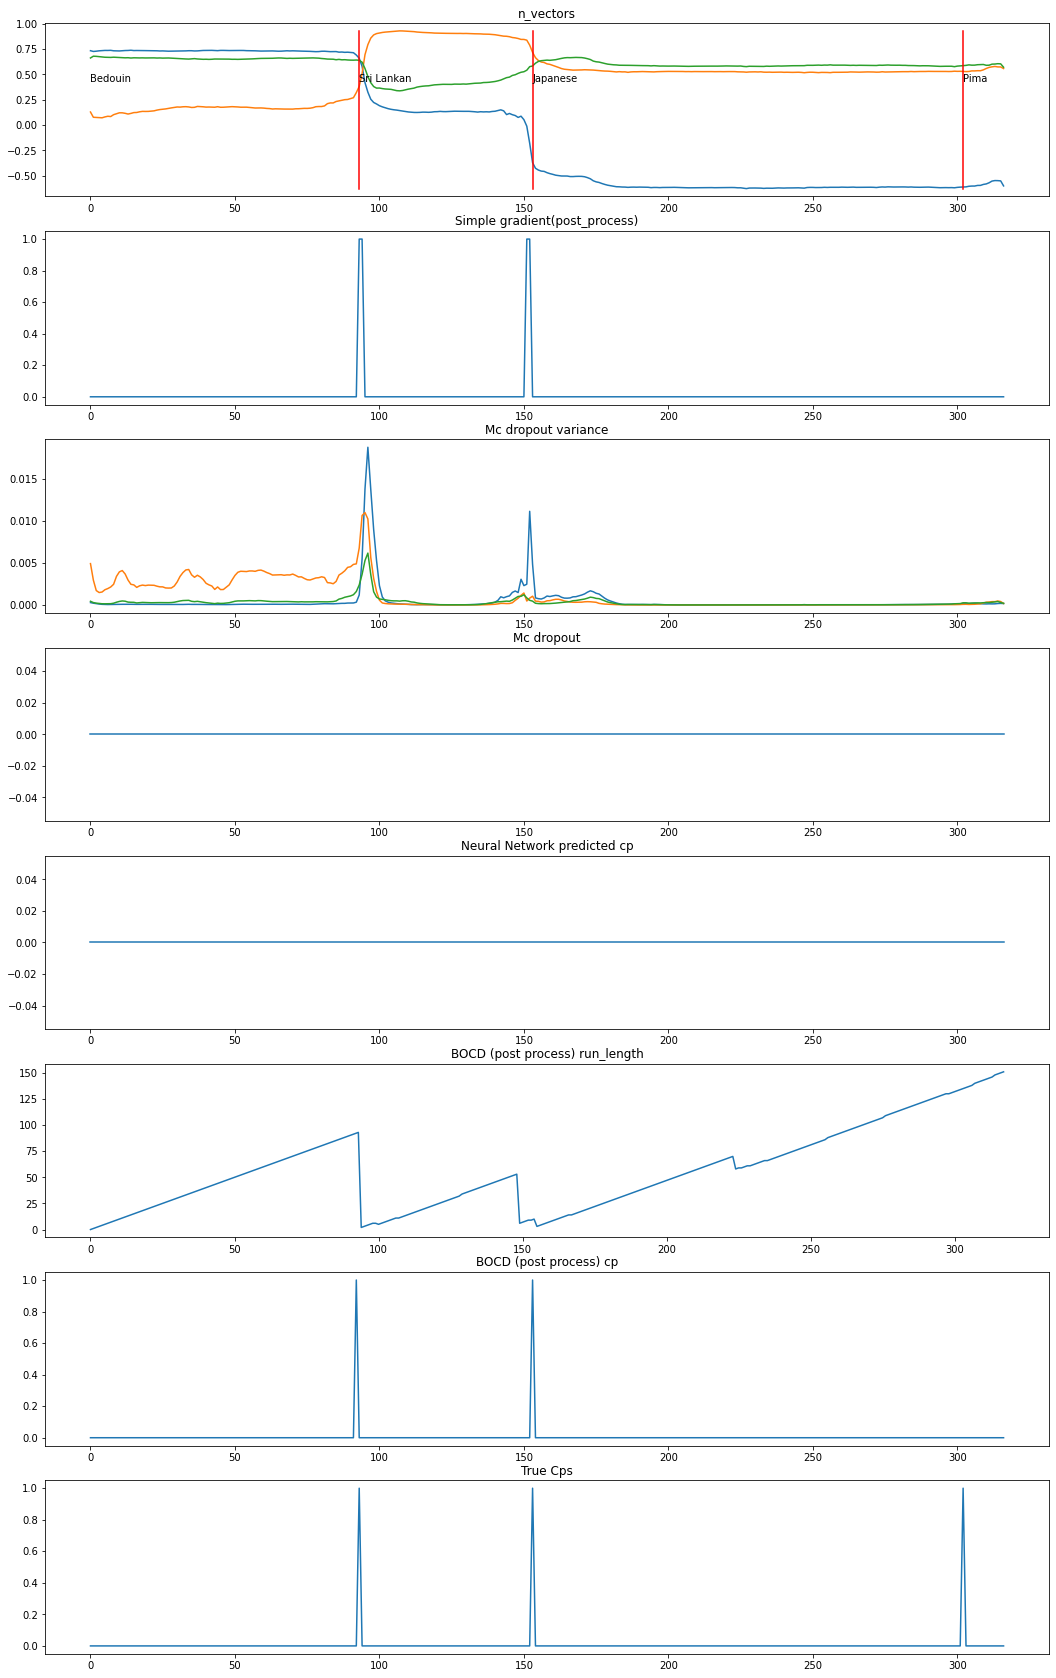

In [28]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

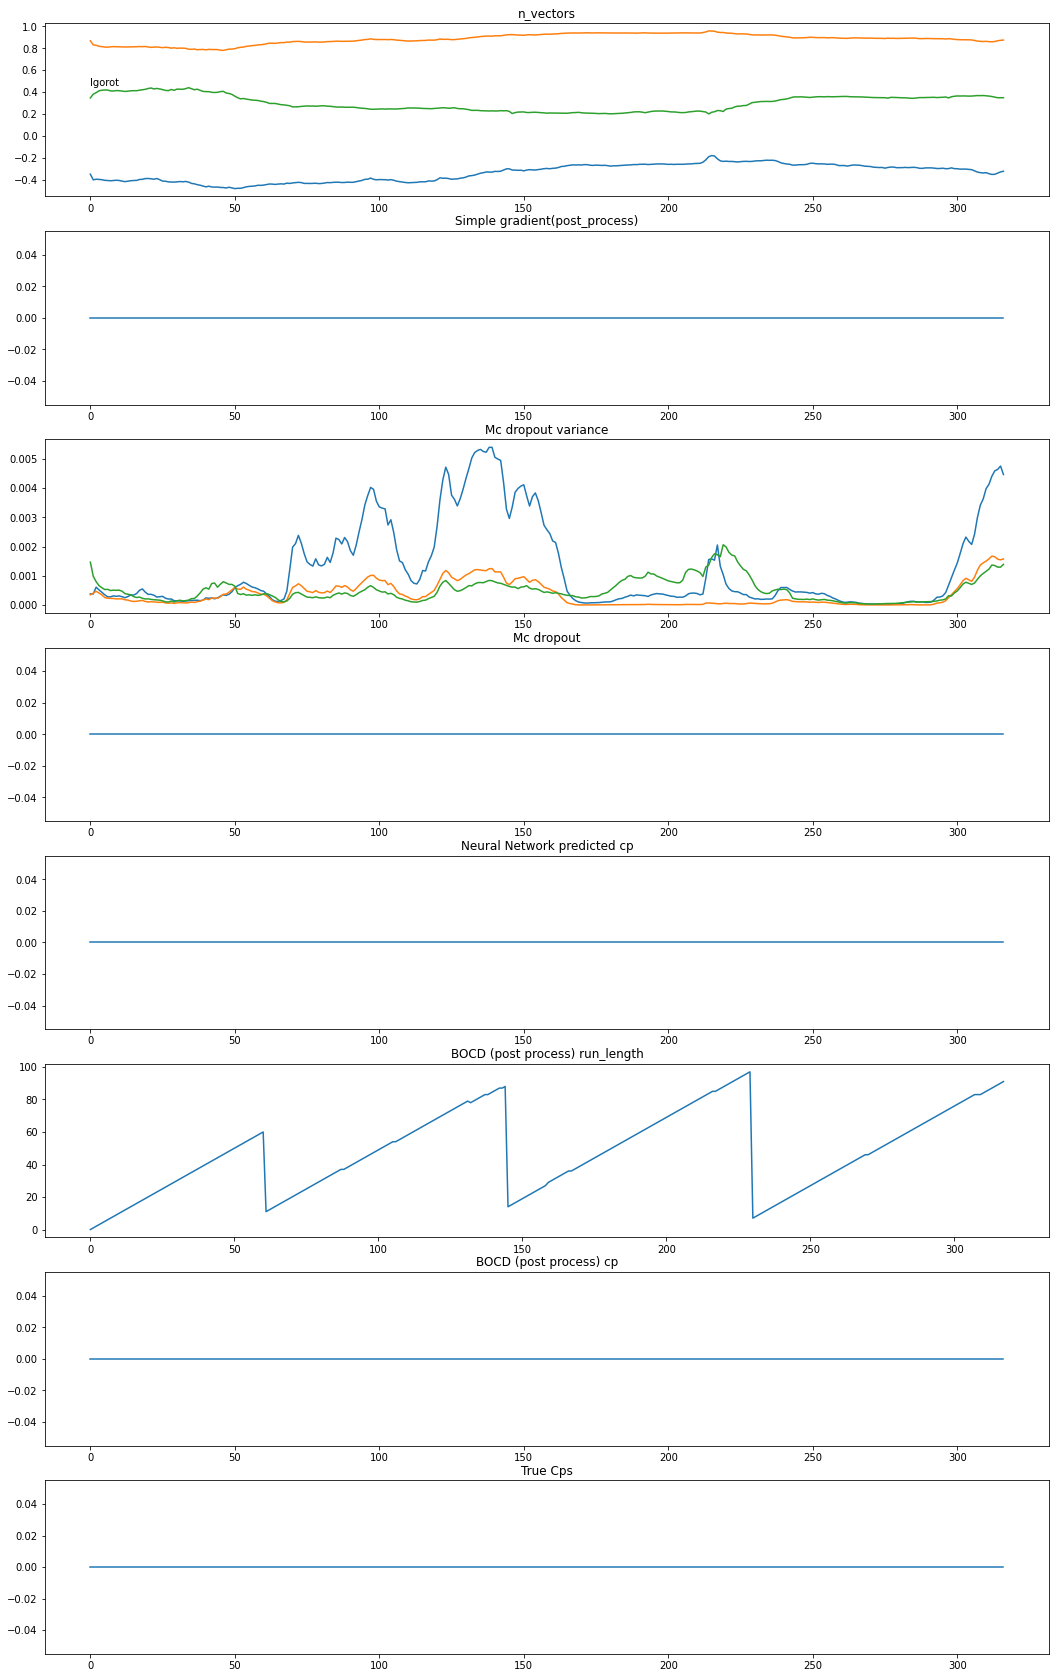

In [29]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [30]:
subset_idx=torch.unique(torch.nonzero(valid_dataset.data['cps'])[:,0])

In [31]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9884511244155912,0.9999970640090077,0.5000,0.4700,nan,neural_network
1,0.5144236042557859,0.5894181224079427,0.9888356516212538,0.9935011839383677,0.7915,0.1000,0.5494,gradient
2,0.16030534351145037,0.044866155586276234,0.986258593820285,0.9972548484221251,0.5211,0.1000,0.0701,mc_dropout
3,0.6274348422496571,0.574839763730049,0.9911500700855247,0.9960129242323484,0.7854,3.0000,0.6000,BOCD


# compute metrics by placing win_tol=0

In [32]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9931178427898535,0.9999947784905138,0.5000,0.4700,nan,neural_network
1,0.22499555344756034,0.47693854467764235,0.9851052244933235,0.9886240713327816,0.7328,0.1000,0.3058,gradient
2,0.047749914118859496,0.017468895312303633,0.9908474136813448,0.9975876626173861,0.5075,0.1000,0.0256,mc_dropout
3,0.20751862197392923,0.22407942691969335,0.9887792230240698,0.9940744569847697,0.6091,3.0000,0.2155,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [33]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9884511244155912,0.9999970640090077,0.5000,0.4700,nan,neural_network
1,0.24392595449286542,0.47693854467764235,0.9768920915087687,0.9827319689783192,0.7298,0.1000,0.3228,gradient
2,0.057724252491694356,0.017468895312303633,0.9853632984018179,0.9966691182191453,0.5071,0.1000,0.0268,mc_dropout
3,0.24081577525661804,0.22407942691969335,0.9828849117328682,0.991748397315917,0.6079,3.0000,0.2321,BOCD


# evaluate by Windows

In [34]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=6383.0, FP=315796.0, TN=833297.0, FN=1574.0)
prCounts:PrCounts(TP=6260.0, FP=304828.0, TN=844265.0, FN=1697.0)
prCounts:PrCounts(TP=6113.0, FP=290113.0, TN=858980.0, FN=1844.0)
prCounts:PrCounts(TP=5863.0, FP=270136.0, TN=878957.0, FN=2094.0)
prCounts:PrCounts(TP=5577.0, FP=245423.0, TN=903670.0, FN=2380.0)
prCounts:PrCounts(TP=5284.0, FP=220472.0, TN=928621.0, FN=2673.0)
prCounts:PrCounts(TP=4929.0, FP=196673.0, TN=952420.0, FN=3028.0)
prCounts:PrCounts(TP=4617.0, FP=174165.0, TN=974928.0, FN=3340.0)
prCounts:PrCounts(TP=4275.0, FP=155015.0, TN=994078.0, FN=3682.0)
prCounts:PrCounts(TP=32.0, FP=481.0, TN=1148612.0, FN=7925.0)
prCounts:PrCounts(TP=10.0, FP=153.0, TN=1148940.0, FN=7947.0)
prCounts:PrCounts(TP=2.0, FP=61.0, TN=1149032.0, FN=7955.0)


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


prCounts:PrCounts(TP=1.0, FP=27.0, TN=1149066.0, FN=7956.0)
prCounts:PrCounts(TP=0.0, FP=12.0, TN=1149081.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=6.0, TN=1149087.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=1.0, TN=1149092.0, FN=7957.0)
prCounts:PrCounts(TP=0.0, FP=0.0, TN=1149093.0, FN=7957.0)


/home/users/richras/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished 'prMetricsByThresh' in 127.8448 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006832,0.280508,0.714631,0.717637,0.499073,0.400000,0.013339
1,0.006819,0.270202,0.724320,0.727465,0.498834,0.405000,0.013301
2,0.006831,0.257635,0.737279,0.740601,0.499118,0.410000,0.013308
3,0.006864,0.241046,0.754931,0.758490,0.499768,0.415000,0.013348
4,0.006974,0.222571,0.776704,0.780541,0.501556,0.420000,0.013524
5,0.007145,0.204977,0.798667,0.802778,0.503878,0.425000,0.013810
6,0.007267,0.186000,0.819660,0.824048,0.505024,0.430000,0.013987
7,0.007492,0.169913,0.839491,0.844127,0.507020,0.435000,0.014351
8,0.007576,0.152947,0.856386,0.861257,0.507102,0.440000,0.014436
9,0.017544,0.001131,0.992695,0.999561,0.500346,0.445000,0.002125


In [35]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1114866.0, TN=34227.0, FN=0.0)
prCounts:PrCounts(TP=5547.0, FP=19863.0, TN=1129230.0, FN=2410.0)
prCounts:PrCounts(TP=4690.0, FP=5736.0, TN=1143357.0, FN=3267.0)
prCounts:PrCounts(TP=3987.0, FP=2474.0, TN=1146619.0, FN=3970.0)
prCounts:PrCounts(TP=3412.0, FP=1293.0, TN=1147800.0, FN=4545.0)
prCounts:PrCounts(TP=2972.0, FP=736.0, TN=1148357.0, FN=4985.0)
prCounts:PrCounts(TP=2685.0, FP=475.0, TN=1148618.0, FN=5272.0)
prCounts:PrCounts(TP=2428.0, FP=331.0, TN=1148762.0, FN=5529.0)
prCounts:PrCounts(TP=2163.0, FP=232.0, TN=1148861.0, FN=5794.0)
prCounts:PrCounts(TP=1962.0, FP=142.0, TN=1148951.0, FN=5995.0)
prCounts:PrCounts(TP=1754.0, FP=108.0, TN=1148985.0, FN=6203.0)
prCounts:PrCounts(TP=1524.0, FP=81.0, TN=1149012.0, FN=6433.0)
prCounts:PrCounts(TP=1347.0, FP=60.0, TN=1149033.0, FN=6610.0)
prCounts:PrCounts(TP=1209.0, FP=46.0, TN=1149047.0, FN=6748.0)
prCounts:PrCounts(TP=1067.0, FP=38.0, TN=1149055.0, FN=6890.0)
prCounts:PrCounts(TP=945.0, FP=30.0, TN=

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.129164,0.603745,0.969282,0.971813,0.787779,0.050000,0.212802
2,0.224996,0.476939,0.985105,0.988624,0.732781,0.100000,0.305752
3,0.302795,0.396255,0.989573,0.993682,0.694968,0.150000,0.343277
4,0.363636,0.335302,0.991394,0.995937,0.665620,0.200000,0.348895
5,0.416379,0.287546,0.992329,0.997209,0.642377,0.250000,0.340172
6,0.461204,0.253236,0.992830,0.997951,0.625594,0.300000,0.326951
7,0.491483,0.221189,0.993070,0.998415,0.609802,0.350000,0.305079
8,0.523469,0.193415,0.993242,0.998781,0.596098,0.400000,0.282463
9,0.563629,0.172552,0.993391,0.999075,0.585814,0.450000,0.264216


In [36]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=7957.0, FP=1118498.0, TN=30595.0, FN=0.0)
prCounts:PrCounts(TP=2532.0, FP=40032.0, TN=1109061.0, FN=5425.0)
prCounts:PrCounts(TP=1087.0, FP=11704.0, TN=1137389.0, FN=6870.0)
prCounts:PrCounts(TP=575.0, FP=4469.0, TN=1144624.0, FN=7382.0)
prCounts:PrCounts(TP=357.0, FP=2373.0, TN=1146720.0, FN=7600.0)
prCounts:PrCounts(TP=262.0, FP=1472.0, TN=1147621.0, FN=7695.0)
prCounts:PrCounts(TP=210.0, FP=1046.0, TN=1148047.0, FN=7747.0)
prCounts:PrCounts(TP=166.0, FP=684.0, TN=1148409.0, FN=7791.0)
prCounts:PrCounts(TP=136.0, FP=460.0, TN=1148633.0, FN=7821.0)
prCounts:PrCounts(TP=111.0, FP=361.0, TN=1148732.0, FN=7846.0)
prCounts:PrCounts(TP=90.0, FP=285.0, TN=1148808.0, FN=7867.0)
prCounts:PrCounts(TP=74.0, FP=232.0, TN=1148861.0, FN=7883.0)
prCounts:PrCounts(TP=60.0, FP=177.0, TN=1148916.0, FN=7897.0)
prCounts:PrCounts(TP=51.0, FP=138.0, TN=1148955.0, FN=7906.0)
prCounts:PrCounts(TP=38.0, FP=106.0, TN=1148987.0, FN=7919.0)
prCounts:PrCounts(TP=26.0, FP=73.0, TN=1149020.0, 

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006877,1.000000,0.006877,0.000000,0.500000,0.000000,0.013660
1,0.029607,0.167525,0.956515,0.961979,0.564752,0.025000,0.050321
2,0.037398,0.063215,0.982368,0.988733,0.525974,0.050000,0.046994
3,0.042417,0.028403,0.988909,0.995560,0.511981,0.075000,0.034023
4,0.047750,0.017469,0.990847,0.997588,0.507528,0.100000,0.025580
5,0.052944,0.012316,0.991693,0.998474,0.505395,0.125000,0.019984
6,0.058736,0.009928,0.992097,0.998898,0.504413,0.150000,0.016986
7,0.063596,0.007289,0.992435,0.999257,0.503273,0.175000,0.013079
8,0.068006,0.005530,0.992640,0.999475,0.502502,0.200000,0.010228
9,0.078585,0.005027,0.992752,0.999592,0.502309,0.225000,0.009450


In [37]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

prCounts:PrCounts(TP=2886.0, FP=1024.0, TN=1148069.0, FN=5071.0)
prCounts:PrCounts(TP=2886.0, FP=1024.0, TN=1148069.0, FN=5071.0)
prCounts:PrCounts(TP=4202.0, FP=2571.0, TN=1146522.0, FN=3755.0)
prCounts:PrCounts(TP=4202.0, FP=2571.0, TN=1146522.0, FN=3755.0)
prCounts:PrCounts(TP=4574.0, FP=3904.0, TN=1145189.0, FN=3383.0)
prCounts:PrCounts(TP=4574.0, FP=3904.0, TN=1145189.0, FN=3383.0)
prCounts:PrCounts(TP=4739.0, FP=5157.0, TN=1143936.0, FN=3218.0)
prCounts:PrCounts(TP=4739.0, FP=5157.0, TN=1143936.0, FN=3218.0)
prCounts:PrCounts(TP=4813.0, FP=6124.0, TN=1142969.0, FN=3144.0)
prCounts:PrCounts(TP=4813.0, FP=6124.0, TN=1142969.0, FN=3144.0)
prCounts:PrCounts(TP=4864.0, FP=7009.0, TN=1142084.0, FN=3093.0)
prCounts:PrCounts(TP=4864.0, FP=7009.0, TN=1142084.0, FN=3093.0)
prCounts:PrCounts(TP=4901.0, FP=7684.0, TN=1141409.0, FN=3056.0)
prCounts:PrCounts(TP=4901.0, FP=7684.0, TN=1141409.0, FN=3056.0)
prCounts:PrCounts(TP=4927.0, FP=8312.0, TN=1140781.0, FN=3030.0)
prCounts:PrCounts(TP=4927

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.318264,0.154832,0.991907,0.997703,0.576268,1.000000,0.208319
1,0.318264,0.154832,0.991907,0.997703,0.576268,1.500000,0.208319
2,0.249743,0.213900,0.990175,0.995550,0.604725,2.000000,0.230436
3,0.249743,0.213900,0.990175,0.995550,0.604725,2.500000,0.230436
4,0.207519,0.224079,0.988779,0.994074,0.609077,3.000000,0.215481
5,0.207519,0.224079,0.988779,0.994074,0.609077,3.500000,0.215481
6,0.180868,0.228352,0.987581,0.992839,0.610596,4.000000,0.201855
7,0.180868,0.228352,0.987581,0.992839,0.610596,4.500000,0.201855
8,0.165017,0.230489,0.986688,0.991924,0.611206,5.000000,0.192334
9,0.165017,0.230489,0.986688,0.991924,0.611206,5.500000,0.192334


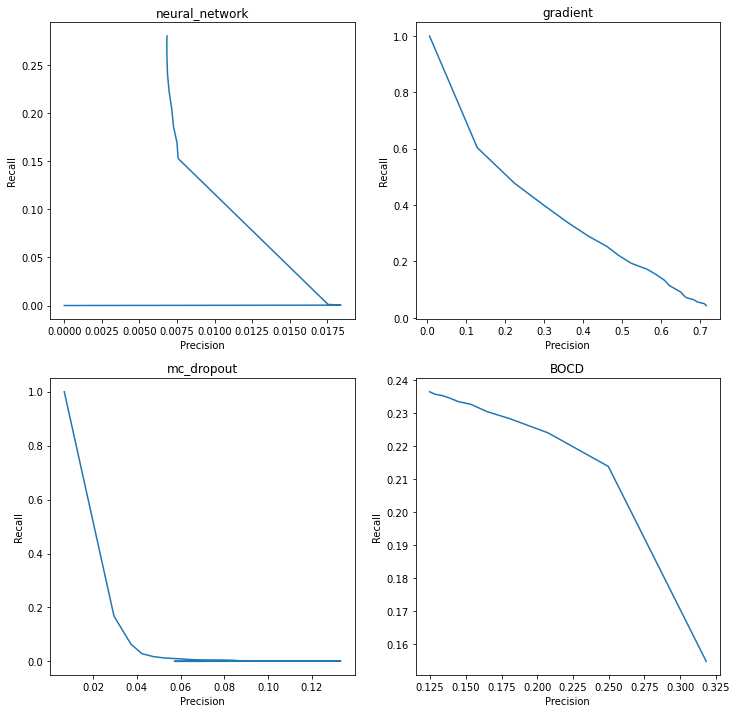

In [38]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [39]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
dataset_type='test'

In [40]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
params.balancedLoss=False
results, test_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 16.7634 secs
Finished '__init__' in 34.6770 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'l1_loss': 0.25601929560223197, 'mse': 0.05753795484154882, 'smooth_l1': 0.028751765775740297, 'weighted_loss': 0.25601929560223197, 'loss_main': 11682.939402294503, 'loss_aux': 13118.319079117246}
at epoch : 102
train loss metrics: {'l1_loss': 0.18589353178125714, 'mse': 0.03726004589822216, 'smooth_l1': 0.01862237257723985, 'weighted_loss': 0.18589353178125714, 'loss_main': 172038.39658658422, 'loss_aux': 10996957.3358706}
best val cp metrics : {'loss_cp': 0.088285782759091, 'prMetrics': OrderedDict([('Precision', array(0.)), ('Recall', array(0.)), ('Accuracy', array(0.98634977)), ('A_major', array(1.)), ('BalancedAccuracy', 0.5)])}
train cp metrics: {'loss_cp': 0.20319076709971257, 'prMetrics': Ord

# Summary Table with test data

compute BOCD

In [41]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [42]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(test_tensor, 'cpu')

Finished 'run_recursive' in 152.9480 secs


In [43]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.0,0.0,0.9915611949067038,0.9999924865778079,0.5000,0.4700,nan,neural_network
1,0.5164932477307947,0.588992678616511,0.9918858052678408,0.9953116245521464,0.7922,0.1000,0.5504,gradient
2,0.21165191740412978,0.03622822519565766,0.990736365300536,0.9988525930966677,0.5175,0.1000,0.0619,mc_dropout
3,0.6020262371736589,0.5850795253723807,0.9932406544144881,0.9967112677719269,0.7909,3.0000,0.5934,BOCD
